# Fig: DCI

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [205]:
from base.dataset import ROFLDS
from analysis.linear import compute_dci

category2latex = {
    'fixate0': '\\fixate{0}',
    'fixate1': '\\fixate{1}',
    'obj1': '\\obj{1}',
}
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
skip_fits = [
    'fixate2_nf-420_beta-0.15_(2023_04_27,13:57).npy',
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15).npy',
]
label2latex = {
    'fix_x': r'$F_x$',
    'fix_y': r'$F_y$',
    'slf_v_x': r'$V_{self, x}$',
    'slf_v_y': r'$V_{self, y}$',
    'slf_v_z': r'$V_{self, z}$',
    'obj0_x': r'$X_{obj}$',
    'obj0_y': r'$Y_{obj}$',
    'obj0_z': r'$Z_{obj}$',
    'obj0_v_x': r'$V_{obj, x}$',
    'obj0_v_y': r'$V_{obj, y}$',
    'obj0_v_z': r'$V_{obj, z}$',
}
pal_model, pal_cat = get_palette()


def _info(fit):
    info = fit.split('_')
    i = info.index([
        e for e in info
        if 'nf-' in e
    ].pop())
    category = info[i - 1]
    nf = int(info[i].split('-')[1])
    beta = info[i + 1].split('-')[1]
    try:
        beta = float(beta)
    except ValueError:
        beta = str(beta)
    tag = 'VAE' if 'vanilla' in info else 'cNVAE'
    if beta == 'ae':
        tag = tag.replace('V', '')
    return category, nf, beta, tag

In [3]:
path = pjoin(tmp_dir, 'trainer_analysis')

In [4]:
df_i_r2 = []
df_dci = collections.defaultdict(list)

for fit in tqdm(sorted(os.listdir(path))):
    if 'reservoir' in fit or fit in skip_fits:
        continue
    if fit in skip_fits:
        continue
    category, nf, beta, tag = _info(fit)    
    if beta == 20.0:
        continue

    # load
    everything = np.load(
        pjoin(path, fit),
        allow_pickle=True,
    ).item()
    
    # info
    df_dci['model'].append(tag)
    df_dci['category'].append(category)
    df_dci['beta'].append(beta)
    df_dci['nf'].append(nf)
    
    # losses
    epe = everything['loss']['epe'].mean()
    df_dci['epe'].append(epe)
    df_dci['epepd'].append(epe / 17 ** 2)
    if isinstance(beta, float):
        kl = everything['loss']['kl'].mean()
        tot_active = (everything['loss']['kl_diag'] > 0.1).sum()
    else:
        kl = np.nan
        tot_active = np.nan

    df_dci['nelbo'].append(epe + kl)
    df_dci['kl'].append(kl)
    df_dci['tot_active'].append(tot_active)

    # load dataset
    sim_path = f"/home/hadi/Documents/MTMST/data/{category}_dim-17_n-750k"
    ds_vld = ROFLDS(sim_path, 'vld')
    ds_tst = ROFLDS(sim_path, 'tst')
    assert everything['f'] \
        == ds_vld.f + ds_vld.f_aux \
        == ds_tst.f + ds_tst.f_aux
    
    # select main ground-truth variables
    select_i, select_lbl = zip(*[
        (i, lbl) for i, lbl in
        enumerate(everything['f'])
        if lbl in label2latex
    ])
    select_i = np.array(select_i)
    select_lbl = list(select_lbl)
    
    # R^2
    g = np.concatenate([ds_vld.g, ds_vld.g_aux], axis=1)[:, select_i]
    g_tst = np.concatenate([ds_tst.g, ds_tst.g_aux], axis=1)[:, select_i]
    lr = sk_linear.LinearRegression().fit(
        everything['data_vld']['z'], g)
    pred = lr.predict(everything['data_tst']['z'])
    r2 = sk_metric.r2_score(
        y_true=g_tst,
        y_pred=pred,
        multioutput='raw_values',
    )
    df_i_r2.append({
        'model': [tag] * len(r2),
        'category': [category] * len(r2),
        'beta': [beta] * len(r2),
        'nf': [nf] * len(r2),
        'f': select_lbl,
        'r2': r2,
    })
    r2 = np.nanmean(r2)
    df_dci['i'].append(r2)

    # DC
    w = everything['importances_mu'][select_i]
    w = np.maximum(0, w)
    d, c = compute_dci(w)

    rho = w.sum(0) / w.sum()
    if isinstance(beta, float):
        spear_r = sp_stats.spearmanr(
            everything['loss']['kl_diag'], rho)
        spear_r = spear_r.correlation
    else:
        spear_r = np.nan

    df_dci['d'].append(d)
    df_dci['c'].append(c)
    df_dci['dci'].append(np.mean([d, c, r2]))
    df_dci['rho_ent'].append(entropy_normalized(rho))
    df_dci['spear_kl_rho'].append(spear_r)

df_dci = pd.DataFrame(df_dci)
df_i_r2 = pd.DataFrame(merge_dicts(df_i_r2))
betas = ['ae'] + sorted([
    b for b in df_dci['beta'].unique()
    if isinstance(b, float)
])

100%|██████████| 85/85 [14:05<00:00,  9.94s/it]


In [6]:
df_dci

,model,category,beta,nf,epe,epepd,nelbo,kl,tot_active,i,d,c,dci,rho_ent,spear_kl_rho
0,cNVAE,fixate0,0.1,280,0.564681,0.001954,24.474018,23.909336,14.0,0.780826,0.324399,0.510160,0.538462,0.545987,0.319565
1,cNVAE,fixate0,0.5,280,2.507265,0.008676,17.201626,14.694360,11.0,0.955640,0.381168,0.471393,0.602734,0.619061,-0.085091
2,cNVAE,fixate0,0.8,280,3.876436,0.013413,16.414843,12.538406,14.0,0.972474,0.400301,0.580116,0.650964,0.459478,0.436461
3,cNVAE,fixate0,1.0,280,4.865442,0.016835,16.239119,11.373676,12.0,0.956546,0.460299,0.570981,0.662609,0.493624,-0.181092
4,cNVAE,fixate0,10.0,280,44.057735,0.152449,44.533688,0.475953,1.0,0.155885,0.341932,0.404930,0.300916,0.647181,0.438073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,VAE,fixate1,1.5,420,21.943741,0.075930,30.526846,8.583105,6.0,0.548411,0.329943,0.138043,0.338799,0.960167,0.330139
77,VAE,fixate1,10.0,420,54.984619,0.190258,55.434219,0.449600,1.0,0.354888,0.306664,0.153363,0.271638,0.946120,0.694643
78,VAE,fixate1,2.0,420,24.347424,0.084247,31.593122,7.245699,6.0,0.548009,0.339428,0.136601,0.341346,0.966365,0.385571
79,VAE,fixate1,5.0,420,41.640739,0.144086,44.016502,2.375763,3.0,0.482426,0.292404,0.135136,0.303322,0.967966,0.585178


In [7]:
_df = df_dci.loc[
    (df_dci['model'] == 'cNVAE') &
    (df_dci['category'] == 'fixate1')
]
best_i_cnvae = _df['i'].argmax()
best_beta_cnvae = _df.iloc[best_i_cnvae]['beta']
_df.iloc[[best_i_cnvae]]

,model,category,beta,nf,epe,epepd,nelbo,kl,tot_active,i,d,c,dci,rho_ent,spear_kl_rho
10,cNVAE,fixate1,0.15,420,1.770626,0.006127,38.868622,37.097996,44.0,0.89788,0.461951,0.699985,0.686606,0.308088,-0.236125


In [8]:
_df = df_dci.loc[
    (df_dci['model'] == 'VAE') &
    (df_dci['category'] == 'fixate1')
]
best_i_vae = _df['i'].argmax()
best_beta_vae = _df.iloc[best_i_vae]['beta']
_df.iloc[[best_i_vae]]

,model,category,beta,nf,epe,epepd,nelbo,kl,tot_active,i,d,c,dci,rho_ent,spear_kl_rho
76,VAE,fixate1,1.5,420,21.943741,0.07593,30.526846,8.583105,6.0,0.548411,0.329943,0.138043,0.338799,0.960167,0.330139


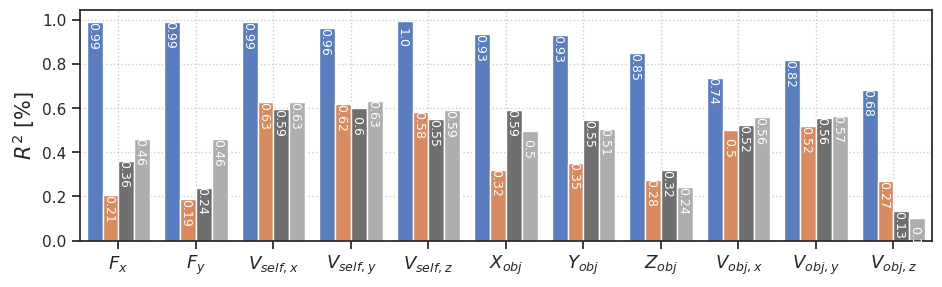

In [13]:
_df = df_i_r2.loc[
    (df_i_r2['category'] == 'fixate1') &
    (df_i_r2['beta'].isin([best_beta_cnvae, 'ae']))
]
fig, ax = create_figure(1, 1, (11, 3))
bp = sns.barplot(
    data=_df,
    x='f',
    y='r2',
    hue='model',
    hue_order=pal_model,
    palette=pal_model,
    dodge=True,
    width=0.82,
    ax=ax,
)
barplot_add_vals(
    bp,
    frac_x=0.35,
    frac_y=0.105,
    fontsize=9.0,
    rotation=-90,
    ha='center',
    color='w',
    decimals=2,
)
ax.tick_params(axis='x', rotation=0, labelsize=13)
ax.set_xticklabels(label2latex.values())
ax.set_ylabel(r'$R^2$ [%]', fontsize=15)
ax.set_xlabel('')
ax.grid()

leg = ax.get_legend()
if leg is not None:
    leg.remove()
    # leg.set_bbox_to_anchor((1.0, 1.04))

plt.show()

In [21]:
_df_cnvae = df_i_r2.loc[
    (df_i_r2['category'] == 'fixate1') &
    (df_i_r2['beta'].isin([best_beta_cnvae, 'ae'])) &
    (df_i_r2['model'] != 'VAE')
]
_df_vae = df_i_r2.loc[
    (df_i_r2['category'] == 'fixate1') &
    (df_i_r2['beta'] == best_beta_vae) &
    (df_i_r2['model'] != 'cNVAE')
]

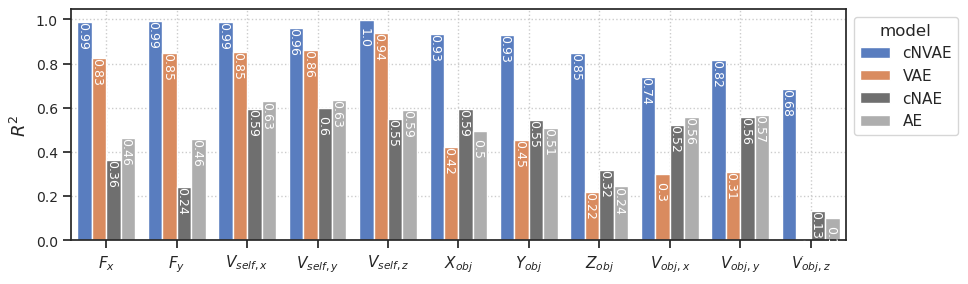

In [35]:
fig, ax = create_figure(1, 1, (10, 3))
bp = sns.barplot(
    data=pd.concat([_df_cnvae, _df_vae]),
    x='f',
    y='r2',
    hue='model',
    hue_order=pal_model,
    palette=pal_model,
    dodge=True,
    width=0.82,
    ax=ax,
)
barplot_add_vals(
    bp,
    frac_x=0.35,
    frac_y=0.105,
    fontsize=9.0,
    rotation=-90,
    ha='center',
    color='w',
    decimals=2,
)

ax.set_ylabel(r'$R^2$', fontsize=13)
ax.tick_params(axis='y', labelsize=10)
ax.set_xticklabels(label2latex.values())
ax.set_xlabel('')
ax.grid()

sns.move_legend(ax, None, bbox_to_anchor=(1, 1))
plt.show()

In [41]:
pca_dci = np.load(
    pjoin(tmp_dir, 'pca_results.npy'),
    allow_pickle=True,
).item()

In [42]:
pal_model['PCA'] = '#5aa57d'

In [43]:
df_to_plot = pd.concat([_df_cnvae, _df_vae])

In [94]:
def barplot_add_vals(
        axes,
        frac_x: float = 0.5,
        frac_y: float = 0.035,
        fontsize: float = 10,
        rotation: float = 0,
        decimals: int = 2,
        ha: str = 'center',
        color: str = 'k', ):
    ymax = axes.get_ybound()[1]

    def _single(_ax):
        for p in _ax.patches:
            h = p.get_height()
            w = p.get_width()
            if h < 0.05:
                continue
            _ax.text(
                x=p.get_x() + frac_x * w,
                y=p.get_y() + h - frac_y * ymax,
                s=np.round(h, decimals),
                fontsize=fontsize,
                rotation=rotation,
                color=color,
                ha=ha,
            )
    if isinstance(axes, np.ndarray):
        for idx, ax in np.ndenumerate(axes):
            _single(ax)
    else:
        _single(axes)
    return

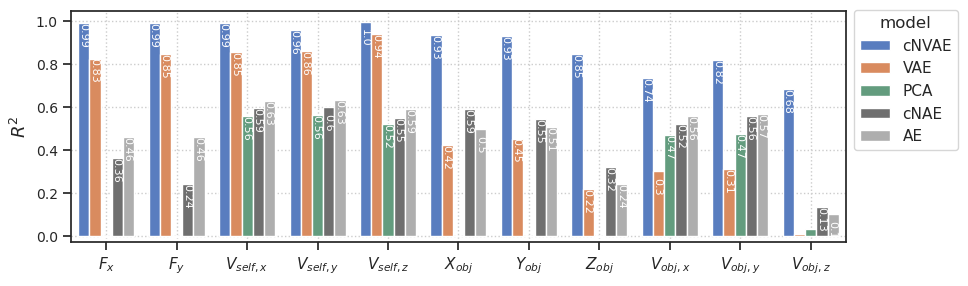

In [101]:
fig, ax = create_figure(1, 1, (10, 3))
bp = sns.barplot(
    data=pd.concat([df_to_plot, pd.DataFrame({'model': ['PCA'] * 11, 'r2': pca_dci['r2'], 'f': select_lbl})]),
    x='f',
    y='r2',
    hue='model',
    hue_order=['cNVAE', 'VAE', 'PCA', 'cNAE', 'AE'],
    palette=pal_model,
    dodge=True,
    width=0.795,
    ax=ax,
)
barplot_add_vals(
    bp,
    frac_x=0.41,
    frac_y=0.10,
    fontsize=8.0,
    rotation=-90,
    ha='center',
    color='w',
    decimals=2,
)
ax.set_ylim(bottom=-0.03)
ax.set_ylabel(r'$R^2$', fontsize=13)
ax.tick_params(axis='y', labelsize=10)
ax.set_xticklabels(label2latex.values())
ax.set_xlabel('')
ax.grid()

sns.move_legend(ax, None, bbox_to_anchor=(1, 1.04))
plt.show()

In [102]:
fig.savefig(pjoin(fig_base_dir, 'untangle_full.pdf'), **kws_fig)
fig.savefig(pjoin(fig_base_dir, 'untangle_full.png'), **kws_fig)

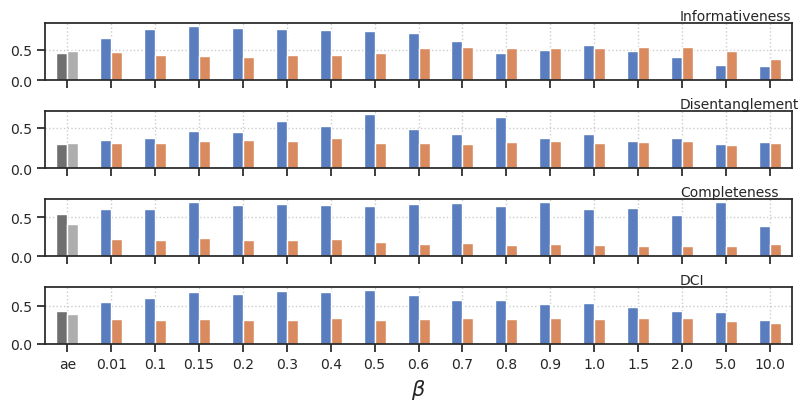

In [113]:
_df1 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] != 'ae')
]
_df2 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] == 'ae')
]
_pal1 = {
    k: v for k, v in pal_model.items()
    if k in _df1['model'].unique()
}
_pal2 = {
    k: v for k, v in pal_model.items()
    if k in _df2['model'].unique()
}
dci = {
    'i': 'Informativeness',
    'd': 'Disentanglement',
    'c': 'Completeness',
    'dci': 'DCI',
}
fig, axes = create_figure(4, 1, (8, 4), 'all', layout='constrained')
for i, (metric, label) in enumerate(dci.items()):
    bp1 = sns.barplot(
        data=_df1,
        x='beta',
        y=metric,
        hue='model',
        order=betas,
        dodge=True,
        width=0.5,
        hue_order=_pal1,
        palette=_pal1,
        ax=axes[i],
    )
    bp2 = sns.barplot(
        data=_df2,
        x='beta',
        y=metric,
        hue='model',
        order=betas,
        dodge=True,
        width=0.5,
        hue_order=_pal2,
        palette=_pal2,
        ax=axes[i],
    )
    axes[i].set_ylim(bottom=0)
    axes[i].set(xlabel='', ylabel='')
    axes[i].annotate(
        text=label,
        xy=(0.85, 1.05),
        xycoords='axes fraction',
        fontsize=10,
    )
    leg = axes[i].get_legend()
    if leg is not None:
        leg.remove()
add_grid(axes)
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=10)
# barplot_add_vals(bp, frac_y=-0.003, fontsize=9, decimals=1)
# ax.set_ylabel(r'$R^2$ [%]', fontsize=17)

axes[-1].tick_params(axis='x', rotation=0)
axes[-1].set_xlabel(r'$\beta$', fontsize=15)
# ax.set_ylabel('Performance', fontsize=13)

ax.tick_params(axis='y', labelsize=10)
plt.show()

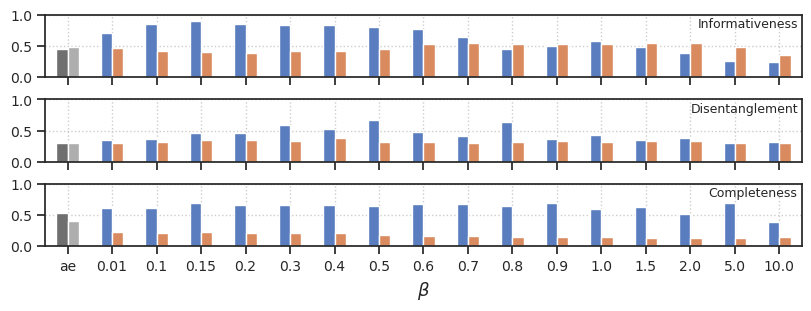

In [159]:
_df1 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] != 'ae')
]
_df2 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] == 'ae')
]
_pal1 = {
    k: v for k, v in pal_model.items()
    if k in _df1['model'].unique()
}
_pal2 = {
    k: v for k, v in pal_model.items()
    if k in _df2['model'].unique()
}
dci = {
    'i': 'Informativeness',
    'd': 'Disentanglement',
    'c': 'Completeness',
}
xy_frac = {
    'i': (0.863, 0.80),
    'd': (0.853, 0.80),
    'c': (0.877, 0.80),
}
fig, axes = create_figure(3, 1, (8, 3), 'all', layout='constrained')
for i, (metric, label) in enumerate(dci.items()):
    bp1 = sns.barplot(
        data=_df1,
        x='beta',
        y=metric,
        hue='model',
        order=betas,
        dodge=True,
        width=0.5,
        hue_order=_pal1,
        palette=_pal1,
        ax=axes[i],
    )
    bp2 = sns.barplot(
        data=_df2,
        x='beta',
        y=metric,
        hue='model',
        order=betas,
        dodge=True,
        width=0.5,
        hue_order=_pal2,
        palette=_pal2,
        ax=axes[i],
    )
    axes[i].set_ylim((0, 1.0))
    axes[i].set(xlabel='', ylabel='')
    axes[i].annotate(
        text=label,
        xy=xy_frac[metric],
        xycoords='axes fraction',
        fontsize=9,
    )
    leg = axes[i].get_legend()
    if leg is not None: #  and i > 0:
        leg.remove()
add_grid(axes)
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=10)
# barplot_add_vals(bp, frac_y=-0.003, fontsize=9, decimals=1)
# ax.set_ylabel(r'$R^2$ [%]', fontsize=17)

axes[-1].tick_params(axis='x', rotation=0)
axes[-1].set_xlabel(r'$\beta$', fontsize=13)

# sns.move_legend(axes[0], None, bbox_to_anchor=(1, 1), fontsize=4)
# ax.set_ylabel('Performance', fontsize=13)

plt.show()

In [151]:
fig.savefig(pjoin(fig_base_dir, 'dci.pdf'), **kws_fig)
fig.savefig(pjoin(fig_base_dir, 'dci.png'), **kws_fig)

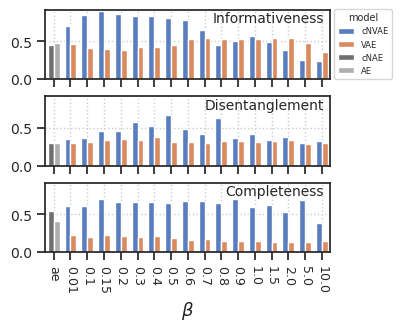

In [268]:
_df1 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] != 'ae')
]
_df2 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] == 'ae')
]
_pal1 = {
    k: v for k, v in pal_model.items()
    if k in _df1['model'].unique()
}
_pal2 = {
    k: v for k, v in pal_model.items()
    if k in _df2['model'].unique()
}
dci = {
    'i': 'Informativeness',
    'd': 'Disentanglement',
    'c': 'Completeness',
}
xy_frac = {
    'i': (0.588, 0.818),
    'd': (0.56, 0.815),
    'c': (0.63, 0.815),
}
fig, axes = create_figure(3, 1, (3.9, 3.2), 'all', layout='constrained')
for i, (metric, label) in enumerate(dci.items()):
    bp1 = sns.barplot(
        data=_df1,
        x='beta',
        y=metric,
        hue='model',
        order=betas,
        dodge=True,
        width=0.7,
        hue_order=_pal1,
        palette=_pal1,
        ax=axes[i],
    )
    bp2 = sns.barplot(
        data=_df2,
        x='beta',
        y=metric,
        hue='model',
        order=betas,
        dodge=True,
        width=0.7,
        hue_order=_pal2,
        palette=_pal2,
        ax=axes[i],
    )
    axes[i].set_ylim((0, 0.92))
    axes[i].set(xlabel='', ylabel='')
    axes[i].annotate(
        text=label,
        xy=xy_frac[metric],
        xycoords='axes fraction',
        fontsize=10,
    )
    leg = axes[i].get_legend()
    if leg is not None and i > 0:
        leg.remove()
add_grid(axes)
for ax in axes.flat:
    ax.tick_params(axis='both', labelsize=10)
# barplot_add_vals(bp, frac_y=-0.003, fontsize=9, decimals=1)
# ax.set_ylabel(r'$R^2$ [%]', fontsize=17)

axes[-1].tick_params(axis='x', rotation=-90, labelsize=9)
axes[-1].set_xlabel(r'$\beta$', fontsize=13)

sns.move_legend(axes[0], None, bbox_to_anchor=(1, 1.063), fontsize=6, title_fontsize=7)
# ax.set_ylabel('Performance', fontsize=13)

plt.show()

In [269]:
fig.savefig(pjoin(fig_base_dir, 'dci.pdf'), **kws_fig)
fig.savefig(pjoin(fig_base_dir, 'dci.png'), **kws_fig)

## Table

In [209]:
which_betas = [0.5, 0.8, 1, 5]

looper = {
    'cNVAE': ['fixate1'],
    'VAE': ['fixate1'],
    'cNAE': ['fixate1'],
    'AE': ['fixate1'],
}
table = ''
for model, cat_list in looper.items():
    first_row_added = False
    for cat in cat_list:
        _df = df_dci.loc[
            (df_dci['model'] == model) &
            (df_dci['category'] == cat)
        ]
        if not len(_df):
            continue
        break
    break


In [211]:
_df

,model,category,beta,nf,epe,epepd,nelbo,kl,tot_active,i,d,c,dci,rho_ent,spear_kl_rho
9,cNVAE,fixate1,0.01,420,0.250954,0.000868,77.794312,77.543358,134.0,0.705911,0.353723,0.613354,0.557663,0.451691,-0.472282
10,cNVAE,fixate1,0.15,420,1.770626,0.006127,38.868622,37.097996,44.0,0.897880,0.461951,0.699985,0.686606,0.308088,-0.236125
11,cNVAE,fixate1,0.1,420,1.394244,0.004824,44.592720,43.198475,55.0,0.848744,0.370521,0.606874,0.608713,0.474551,-0.427578
12,cNVAE,fixate1,0.2,420,2.412863,0.008349,36.331406,33.918545,46.0,0.855109,0.454190,0.662509,0.657269,0.390686,-0.206275
13,cNVAE,fixate1,0.3,420,3.390862,0.011733,32.136974,28.746113,42.0,0.840468,0.581333,0.667747,0.696516,0.392053,-0.271202
14,cNVAE,fixate1,0.4,420,4.255143,0.014724,30.936302,26.681160,45.0,0.833012,0.527683,0.664751,0.675149,0.411994,-0.279859
15,cNVAE,fixate1,0.5,420,5.370134,0.018582,29.862501,24.492367,36.0,0.811089,0.672083,0.651275,0.711483,0.295805,-0.379627
16,cNVAE,fixate1,0.6,420,6.710308,0.023219,28.884995,22.174686,31.0,0.777358,0.484406,0.675671,0.645812,0.221422,-0.284253
17,cNVAE,fixate1,0.7,420,9.707503,0.033590,27.612862,17.905359,23.0,0.647797,0.418998,0.679967,0.582254,0.375835,-0.313592
18,cNVAE,fixate1,0.8,420,18.358315,0.063524,29.793653,11.435339,13.0,0.458326,0.630447,0.645154,0.577976,0.249180,0.178956


In [233]:
if 'VAE' in model:
    d_str = []
    for b in which_betas:
        _df1 = _df.loc[_df['beta'] == b]
        val = np.round(_df1['d'].item(), 2)
        d_str.append(str(val))
    r_str = ' & '.join(r_str)

In [234]:
r_str

'0.67 & 0.63 & 0.42 & 0.31'

In [231]:
_df.loc[_df['beta'] == b]

,model,category,beta,nf,epe,epepd,nelbo,kl,tot_active,i,d,c,dci,rho_ent,spear_kl_rho
24,cNVAE,fixate1,5.0,420,41.843102,0.144786,44.209438,2.366338,3.0,0.256634,0.305863,0.694076,0.418858,0.332169,0.287267


In [225]:
_df1

{'model': 24    cNVAE
 Name: model, dtype: object,
 'category': 24    fixate1
 Name: category, dtype: object,
 'beta': 24    5.0
 Name: beta, dtype: object,
 'nf': 24    420
 Name: nf, dtype: int64,
 'epe': 24    41.843102
 Name: epe, dtype: float32,
 'epepd': 24    0.144786
 Name: epepd, dtype: float64,
 'nelbo': 24    44.209438
 Name: nelbo, dtype: float64,
 'kl': 24    2.366338
 Name: kl, dtype: float64,
 'tot_active': 24    3.0
 Name: tot_active, dtype: float64,
 'i': 24    0.256634
 Name: i, dtype: float64,
 'd': 24    0.305863
 Name: d, dtype: float64,
 'c': 24    0.694076
 Name: c, dtype: float64,
 'dci': 24    0.418858
 Name: dci, dtype: float64,
 'rho_ent': 24    0.332169
 Name: rho_ent, dtype: float64,
 'spear_kl_rho': 24    0.287267
 Name: spear_kl_rho, dtype: float64}

In [219]:
_df1['epepd'], _df1['nelbo']

(24    0.144786
 Name: epepd, dtype: float64,
 24    44.209438
 Name: nelbo, dtype: float64)

In [220]:
_df1['d'], _df1['c'], _df1['i']

(24    0.305863
 Name: d, dtype: float64,
 24    0.694076
 Name: c, dtype: float64,
 24    0.256634
 Name: i, dtype: float64)

In [ ]:
which_betas = [0.5, 0.8, 1, 5]

looper = {
    'cNVAE': ['fixate1'],
    'VAE': ['fixate1'],
    'cNAE': ['fixate1'],
    'AE': ['fixate1'],
}
table = ''
for model, cat_list in looper.items():
    first_row_added = False
    for cat in cat_list:
        _df = df_dci.loc[
            (df_dci['model'] == model) &
            (df_dci['category'] == cat)
        ]
        if not len(_df):
            continue

        mu = _df.groupby(['beta']).mean()
        sd = _df.groupby(['beta']).std()
        mu, sd = dict(mu['perf']), dict(sd['perf'])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            _df = _df.pivot(columns='beta', values='perf', index='index')
        assert len(_df) == 141

        mu['pool'] = _df.max(1).mean()
        sd['pool'] = _df.max(1).std()
        se = {
            k: v / np.sqrt(len(_df))
            for k, v in sd.items()
        }

        if 'VAE' in model:
            r_str = []
            for b in which_betas:
                if mu[b] > 0.5:
                    r_str.append(f"$\mathbf{'{'}{mu[b]:0.3f} \\pm {se[b]:0.3f}{'}'}$")
                else:
                    r_str.append(f"${mu[b]:0.3f} \\pm {se[b]:0.3f}$")
            r_str = ' & '.join(r_str)
        else:
            if mu['ae'] > 0.5:
                r_str = f"$\mathbf{'{'}{mu['ae']:0.3f} \\pm {se['ae']:0.3f}{'}'}$"
            else:
                r_str = f"${mu['ae']:0.3f} \\pm {se['ae']:0.3f}$"

        if first_row_added:
            table += f"& {cat} & {r_str} \\\\\n"
        else:
            model_str = f"{model} "
            table += model_str + f"& {cat} & {r_str} \\\\\n"
            first_row_added = True

In [12]:
df_dci

,model,category,beta,nf,epe,epepd,nelbo,kl,tot_active,i,d,c,dci,rho_ent,spear_kl_rho
0,cNVAE,fixate0,0.1,280,0.564681,0.001954,24.474018,23.909336,14.0,0.780826,0.324399,0.510160,0.538462,0.545987,0.319565
1,cNVAE,fixate0,0.5,280,2.507265,0.008676,17.201626,14.694360,11.0,0.955640,0.381168,0.471393,0.602734,0.619061,-0.085091
2,cNVAE,fixate0,0.8,280,3.876436,0.013413,16.414843,12.538406,14.0,0.972474,0.400301,0.580116,0.650964,0.459478,0.436461
3,cNVAE,fixate0,1.0,280,4.865442,0.016835,16.239119,11.373676,12.0,0.956546,0.460299,0.570981,0.662609,0.493624,-0.181092
4,cNVAE,fixate0,10.0,280,44.057735,0.152449,44.533688,0.475953,1.0,0.155885,0.341932,0.404930,0.300916,0.647181,0.438073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,VAE,fixate1,1.5,420,21.943741,0.075930,30.526846,8.583105,6.0,0.548411,0.329943,0.138043,0.338799,0.960167,0.330139
76,VAE,fixate1,10.0,420,54.984619,0.190258,55.434219,0.449600,1.0,0.354888,0.306664,0.153363,0.271638,0.946120,0.694643
77,VAE,fixate1,2.0,420,24.347424,0.084247,31.593122,7.245699,6.0,0.548009,0.339428,0.136601,0.341346,0.966365,0.385571
78,VAE,fixate1,5.0,420,41.640739,0.144086,44.016502,2.375763,3.0,0.482426,0.292404,0.135136,0.303322,0.967966,0.585178


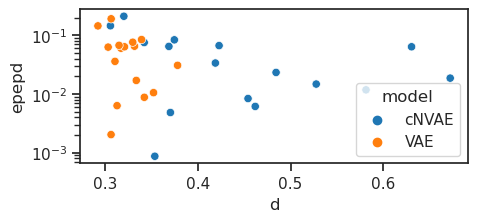

In [23]:
fig, ax = create_figure(1, 1, (5, 2))
_df1 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] != 'ae')
]
sns.scatterplot(
    data=_df1,
    y='epepd',
    x='d',
    hue='model',
    ax=ax,
)
ax.set_yscale('log')

In [60]:
_df1 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['model'] == 'cNVAE') &
    (df_dci['beta'] != 'ae')
]

In [61]:
sp_stats.linregress(_df1['epepd'], _df1['i'])

LinregressResult(slope=-3.509708888366657, intercept=0.8147292378630605, rvalue=-0.9117112386579744, pvalue=8.855173092613849e-07, stderr=0.42268187758565506, intercept_stderr=0.03220091128663793)

In [62]:
sp_stats.linregress(_df1['epepd'], _df1['d'])

LinregressResult(slope=-0.9265798819499973, intercept=0.49122087378201207, rvalue=-0.4814875089068858, pvalue=0.058978754508755865, stderr=0.45077770944958045, intercept_stderr=0.034341318617423525)

In [63]:
sp_stats.linregress(_df1['epepd'], _df1['c'])

LinregressResult(slope=-0.8609464432217797, intercept=0.6763173533207186, rvalue=-0.6351173159446272, pvalue=0.008205424162820307, stderr=0.2798396510601218, intercept_stderr=0.021318850549594783)

In [64]:
sp_stats.pearsonr(_df1['epepd'], _df1['i'])

(-0.9117112386579744, 8.855173092613863e-07)

In [65]:
sp_stats.pearsonr(_df1['epepd'], _df1['d'])

(-0.48148750890688574, 0.05897875450875588)

In [66]:
sp_stats.pearsonr(_df1['epepd'], _df1['c'])

(-0.6351173159446273, 0.008205424162820303)

In [67]:
sp_stats.pearsonr(_df1['epepd'], _df1['dci'])

(-0.8957552616847395, 2.7121785044152643e-06)

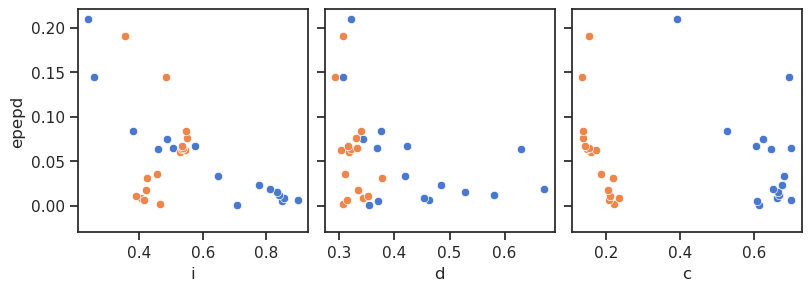

In [57]:
fig, axes = create_figure(1, 3, (8, 2.8), sharey='all', layout='constrained')

for model in ['cNVAE', 'VAE']:
    _df = df_dci.loc[
        (df_dci['category'] == 'fixate1') &
        (df_dci['model'] == model) &
        (df_dci['beta'] != 'ae')
    ]
    for i, item in enumerate(['i', 'd', 'c']):
        sns.scatterplot(
            data=_df,
            y='epepd',
            x=item,
            color=pal_model[model],
            ax=axes[i],
        )
        axes[i].set_ylim(bottom=-0.03)
        if i > 0:
            axes[i].set_ylabel('')
plt.show()

<Axes: xlabel='beta', ylabel='spear_kl_rho'>

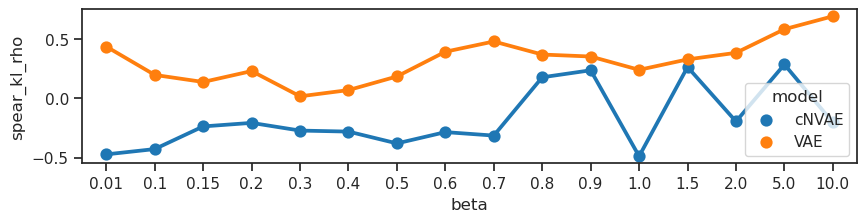

In [17]:
fig, ax = create_figure(1, 1, (10, 2))
_df1 = df_dci.loc[
    (df_dci['category'] == 'fixate1') &
    (df_dci['beta'] != 'ae')
]
sns.pointplot(data=_df1, x='beta', y='spear_kl_rho', hue='model')

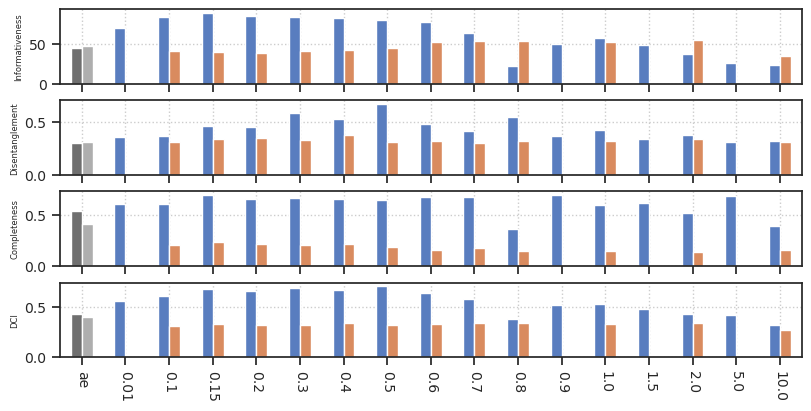

In [10]:
_df = df_dci.loc[df_dci['category'] == 'fixate1']
_df.iloc[[_df['dci'].argmax()]]

,model,category,beta,nf,epe,epepd,nelbo,kl,tot_active,i,d,c,dci,rho_ent,spear_kl_rho
14,cNVAE,fixate1,0.5,420,5.370134,0.018582,29.862501,24.492367,36.0,81.108896,0.672083,0.651275,0.711483,0.295805,-0.379627


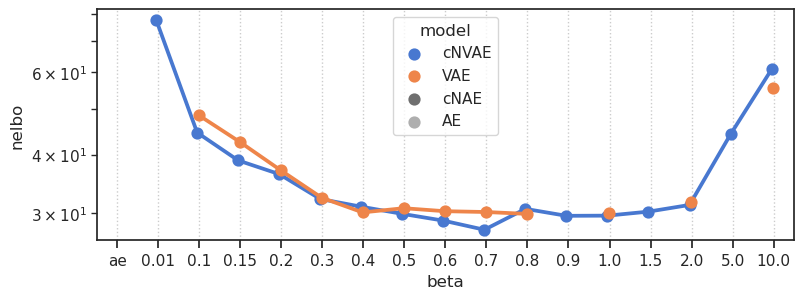

In [11]:
fig, ax = create_figure(1, 1, (9, 3))
sns.pointplot(
    data=_df,
    y='nelbo',
    x='beta',
    hue='model',
    hue_order=pal_model,
    palette=pal_model,
    order=betas,
    dodge=True,
    ax=ax,
)
ax.set_yscale('log')
ax.grid()
plt.show()
# ax.set(xlim=(26, 34), ylim=(0, 1.5))

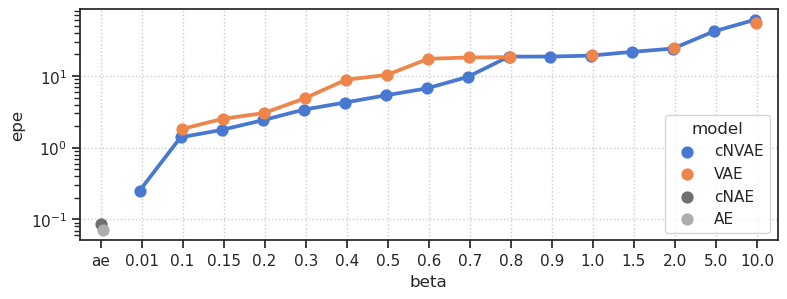

In [12]:
fig, ax = create_figure(1, 1, (9, 3))
sns.pointplot(
    data=_df,
    y='epe',
    x='beta',
    hue='model',
    hue_order=pal_model,
    palette=pal_model,
    order=betas,
    dodge=True,
    ax=ax,
)
ax.set_yscale('log')
ax.grid()
plt.show()

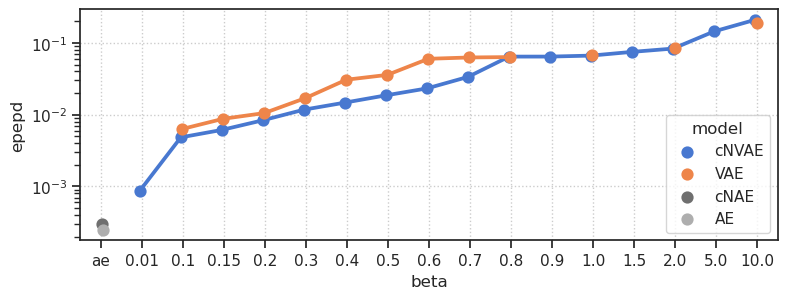

In [13]:
fig, ax = create_figure(1, 1, (9, 3))
sns.pointplot(
    data=_df,
    y='epepd',
    x='beta',
    hue='model',
    hue_order=pal_model,
    palette=pal_model,
    order=betas,
    dodge=True,
    ax=ax,
)
ax.set_yscale('log')
ax.grid()
plt.show()

## Old code (ignore)

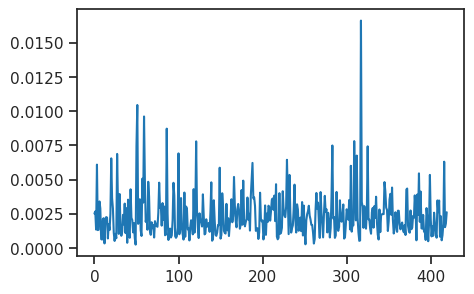

In [18]:
plt.plot(rho)

In [37]:
denum = w.sum(0, keepdims=True)
denum[denum == 0] = np.nan
p_disentang = w / denum

In [44]:
p_disentang.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
1 - entropy_normalized(p_disentang, 0)

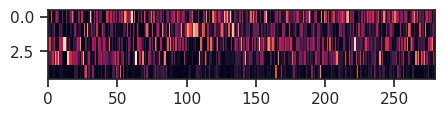

In [43]:
plt.imshow(p_disentang, aspect=10)

In [5]:
list(everything)

['val',
 'loss',
 'data_trn',
 'data_vld',
 'data_tst',
 'importances_mu',
 'importances_sd',
 'f']

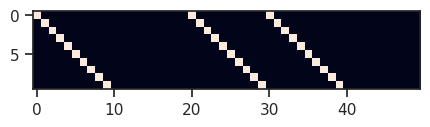

(1.0, 0.7191702893506186)

In [61]:
w_test = np.zeros((10, 50))
for i in range(10):
    w_test[i, i] = 1
    w_test[i, i + 20] = 1
    w_test[i, i + 30] = 1
    
plt.imshow(w_test)
plt.show()

compute_dci(w_test)

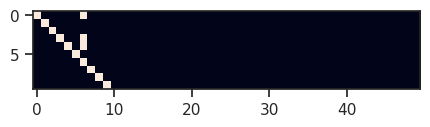

(0.8147507718990885, 0.9468448539593325)

In [80]:
w_test = np.zeros((10, 50))
for i in range(10):
    w_test[i, i] = 1
w_test[4, 6] = 1
w_test[3, 6] = 1
w_test[0, 6] = 1
plt.imshow(w_test)
plt.show()

compute_dci(w_test)

In [81]:
denum = w_test.sum(0, keepdims=True)
denum[denum == 0] = np.nan
p_disentang = w_test / denum

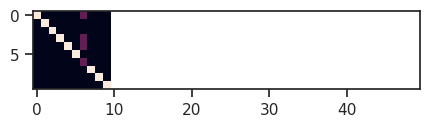

In [82]:
plt.imshow(p_disentang)

In [83]:
d_i = 1 - entropy_normalized(p_disentang, 0)
d_i.shape

(50,)

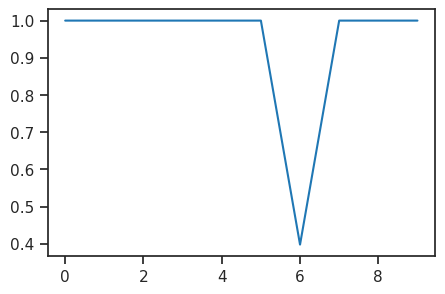

In [84]:
plt.plot(d_i)

In [85]:
rho = w_test.sum(0) / w_test.sum()

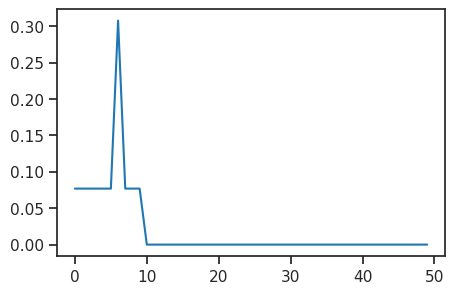

In [86]:
plt.plot(rho)

In [89]:
np.nansum(d_i * rho)

0.8147507718990885

In [90]:
np.nanmean(d_i)

0.9397940008672038

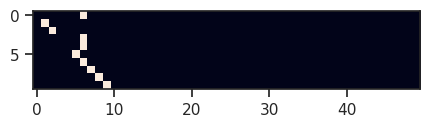

(0.7591760034688151, 1.0)

In [95]:
w_test = np.zeros((10, 50))
for i in range(10):
    w_test[i, i] = 1
w_test[4, 4] = 0
w_test[3, 3] = 0
w_test[0, 0] = 0
w_test[4, 6] = 1
w_test[3, 6] = 1
w_test[0, 6] = 1
plt.imshow(w_test)
plt.show()

compute_dci(w_test)

In [19]:

perm_mu.shape

(5, 280)

In [8]:
everything['importances_mu'].shape

(8, 280)

In [24]:
w = perm_mu

d, c

(0.32439875181597555, 0.510160201141466)

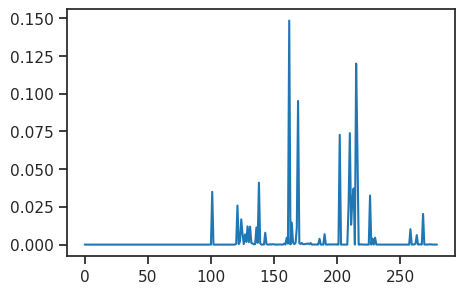

In [25]:
plt.plot(rho)

In [29]:
sp_stats.pearsonr(everything['loss']['kl_diag'], rho)

(0.13922166630787042, 0.01977638395660314)

0.31956475392361056

<Axes: >

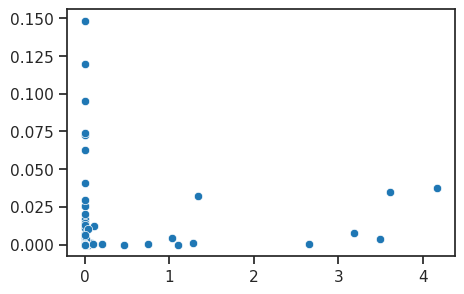

In [26]:
sns.scatterplot(
    x=everything['loss']['kl_diag'],
    y=rho,
)

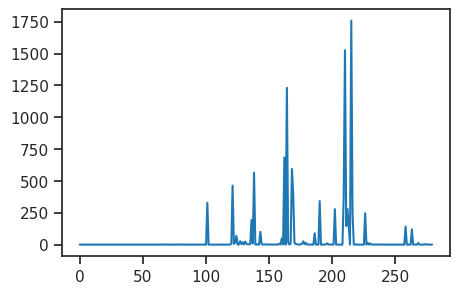

In [16]:
plt.plot(perm_mu[4])

In [7]:
list(everything)

['val',
 'loss',
 'data_trn',
 'data_vld',
 'data_tst',
 'importances_mu',
 'importances_sd',
 'f']

In [7]:
everything['loss']['epe'].mean(), everything['loss']['kl'].mean()

(0.5646815, 23.909336)

In [8]:
min(everything['loss']['kl_diag']), max(everything['loss']['kl_diag'])

(0.0, 4.16862)

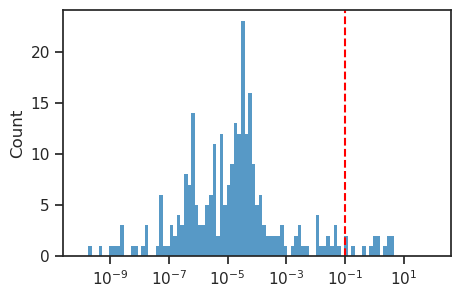

In [9]:
ax = sns.histplot(everything['loss']['kl_diag'], bins=np.logspace(-10, 2, 100))
ax.axvline(0.1, color='r', ls='--')
ax.set_xscale('log')
plt.show()

In [10]:
(everything['loss']['kl_diag'] <= 0.1).sum(), (everything['loss']['kl_diag'] > 0.1).sum()

(266, 14)

In [4]:
list(everything)

NameError: name 'everything' is not defined

In [16]:
everything['data_tst']

{'x': [],
 'y': [],
 'z': array([[-0.00924373, -0.00668725, -0.00218269, ..., -0.1080126 ,
          0.02699516, -0.05209924],
        [-0.00933603, -0.00662458, -0.00210156, ..., -0.21367927,
          0.0869858 , -0.14760306],
        [-0.00917179, -0.00669082, -0.00227596, ...,  0.29358372,
         -0.3044515 ,  0.10462018],
        ...,
        [-0.00911674, -0.00647449, -0.00243915, ...,  0.12978122,
          0.05793152, -0.01021165],
        [-0.00919618, -0.00654394, -0.00228771, ..., -0.2134269 ,
          0.08058421, -0.17979455],
        [-0.00907419, -0.00659908, -0.00244587, ...,  0.05912931,
         -0.00423615,  0.00466096]], dtype=float32)}

In [15]:
everything['data_vld']

{'x': [],
 'y': [],
 'z': array([[-0.00936357, -0.00655375, -0.00210097, ..., -0.23126903,
         -0.47400546,  0.05585103],
        [-0.00927482, -0.00662192, -0.00220085, ...,  0.15709946,
         -0.46287477,  0.24429414],
        [-0.00905203, -0.00668927, -0.00244803, ..., -0.08507252,
         -0.28464168, -0.05053638],
        ...,
        [-0.00924551, -0.00653933, -0.00222625, ...,  0.24655789,
         -0.35837793,  0.14422555],
        [-0.00912849, -0.00662036, -0.00236502, ...,  0.15217587,
          0.18675563,  0.05085435],
        [-0.00917892, -0.00665259, -0.00225591, ...,  0.00721657,
          0.14724572, -0.17497481]], dtype=float32)}

In [14]:
everything['f']

['fix_x',
 'fix_y',
 'slf_v_norm',
 'slf_v_theta',
 'slf_v_phi',
 'slf_v_x',
 'slf_v_y',
 'slf_v_z']